In [2]:
import argparse
import logging
import numpy as np
from ibicus.debias import QuantileMapping
import xarray as xr

from deepdown.utils.data_loader import DataLoader
from deepdown.config import Config
from deepdown.bias_correction_classic import correct_bias
import matplotlib.pyplot as plt

from argparse import Namespace
cli_args = Namespace(config_file="../config.yaml")
config = Config(cli_args)
conf = config.config


In [25]:
input_data_clim_debiased = xr.open_dataset("/storage/workspaces/giub_hydro/hydro/data/tmp/input_data_clim_debiased.nc")
input_data_clim_debiased

<xarray.Dataset>
Dimensions:    (time: 4748, y: 29, x: 61)
Coordinates:
  * time       (time) datetime64[ns] 2010-01-01 2010-01-02 ... 2022-12-31
  * y          (y) float64 48.2 48.1 48.0 47.9 47.8 ... 45.8 45.7 45.6 45.5 45.4
  * x          (x) float64 5.0 5.1 5.2 5.3 5.4 5.5 ... 10.6 10.7 10.8 10.9 11.0
Data variables:
    tp         (time, y, x) float32 ...
    t          (time, y, x) float32 ...
    t_max      (time, y, x) float32 ...
    t_min      (time, y, x) float32 ...
    tp_deb     (time, y, x) float32 ...
    t_deb      (time, y, x) float32 ...
    t_min_deb  (time, y, x) float32 ...
    t_max_deb  (time, y, x) float32 ...

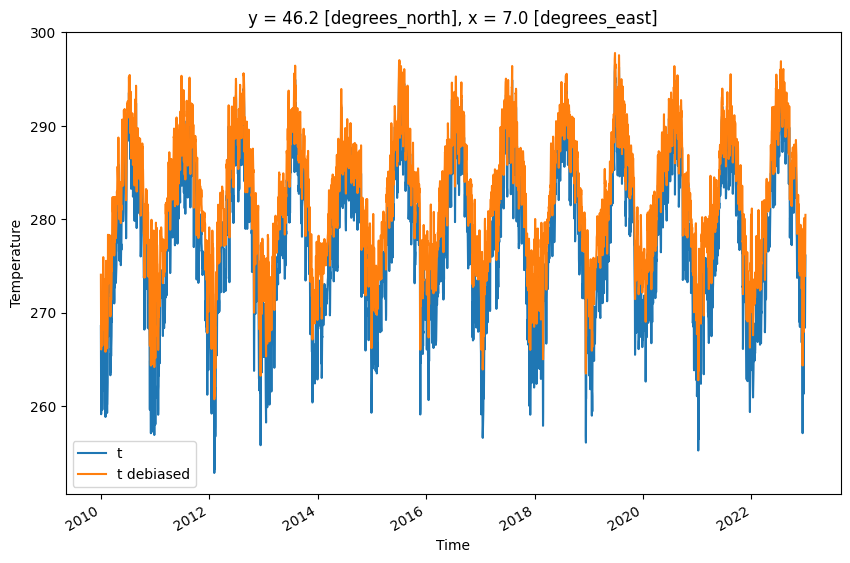

In [26]:
plt.figure(figsize=(10, 6))
input_data_clim_debiased['t'][:,20,20].plot(label='t')
input_data_clim_debiased['t_deb'][:,20,20].plot(label='t debiased')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.legend()
plt.show()

In [ ]:

# Load target data for the historical period
target_data_hist = DataLoader(path_tmp=conf.path_tmp)
target_data_hist.load(conf.period_hist_start, conf.period_hist_end,
                        conf.path_targets)

# Load input data (e.g. climate model) for the historical period
input_data_hist = DataLoader(path_tmp=conf.path_tmp)
input_data_hist.load(conf.period_hist_start, conf.period_hist_end, conf.path_inputs)

# Load input data (e.g. climate model) for the future period
input_data_clim = DataLoader(path_tmp=conf.path_tmp)
input_data_clim.load(conf.period_clim_start, conf.period_clim_end, conf.path_inputs)

# Coarsen the target data to the resolution of the input data
target_data_hist.coarsen(
    x_axis=input_data_hist.data.x, y_axis=input_data_hist.data.y,
    from_proj='CH1903_LV95', to_proj='WGS84')

    # Create a new dataset for debiased variables
    # debiased_data = xr.Dataset(coords=input_data_clim.data.coords)
    # Bias correct each input variable
for var_target, var_input in zip(conf.target_vars, conf.input_vars):

    # Map to the ibicus variable names
    var_ibicus = var_target
    if var_target == 'tp':
        var_ibicus = 'pr'
    elif var_target == 't':
        var_ibicus = 'tas'
    elif var_target == 't_min':
        var_ibicus = 'tasmin'
    elif var_target == 't_max':
        var_ibicus = 'tasmax'

    target_array_hist = target_data_hist.data[var_target].values
    input_array_hist = input_data_hist.data[var_input].values
    input_array_clim = input_data_clim.data[var_input].values

In [12]:

var_target = 'tp'
if var_target == 'tp':
        # mm/day to kg/m^2/s
        target_array_hist /= 86400
        input_array_hist /= 86400
        input_array_clim /= 86400
elif var_target in ['t', 't_min', 't_max']:
        # Degree Celsius to Kelvin
        target_array_hist += 273.15 # I think this's only applies to the target
print(var_target)

tp


In [ ]:
target_array_hist = np.nan_to_num(target_array_hist)
input_array_hist = np.nan_to_num(input_array_hist)
input_array_clim = np.nan_to_num(input_array_clim)

debiaser = QuantileMapping.from_variable(var_ibicus)


In [ ]:
debiased_ts = debiaser.apply(
    target_array_hist,
    input_array_hist,
    input_array_clim)